## Paper: <span style="font-size:medium; font-weight:normal;">H. Nkiama, S. Zainudeen, and M. Saidu, “A Subset Feature Elimination Mechanism for Intrusion Detection System,” *International Journal of Advanced Computer Science and Applications*, vol. 7, Apr. 2016, doi: <a href="http://dx.doi.org/10.14569/IJACSA.2016.070419">10.14569/IJACSA.2016.070419.</a></span>

### Import required packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectPercentile, f_classif, RFECV

## Step 1: Import dataset

In [2]:
# List of features of NSL-KDD dataset
feature_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land",
                 "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised",
                 "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells", "num_access_files",
                 "num_outbound_cmds", "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
                 "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
                 "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
                 "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
                 "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", 
                 "dst_host_srv_rerror_rate", "class_label", "difficulty_score"]

# Import data as DataFrame
df_train = pd.read_csv('data/KDDTrain+.txt', header=None, names=feature_names)
df_test = pd.read_csv('data/KDDTest+.txt', header=None, names=feature_names)

# Remove difficulty_score column
df_train = df_train.drop("difficulty_score", axis=1)
df_test = df_test.drop("difficulty_score", axis=1)

#### Dataset dimensions

In [3]:
print('Training set:', df_train.shape)
print('Test set:', df_test.shape)

Training set: (125973, 42)
Test set: (22544, 42)


#### Display first five entries

In [4]:
df_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class_label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


#### Data distribution per class

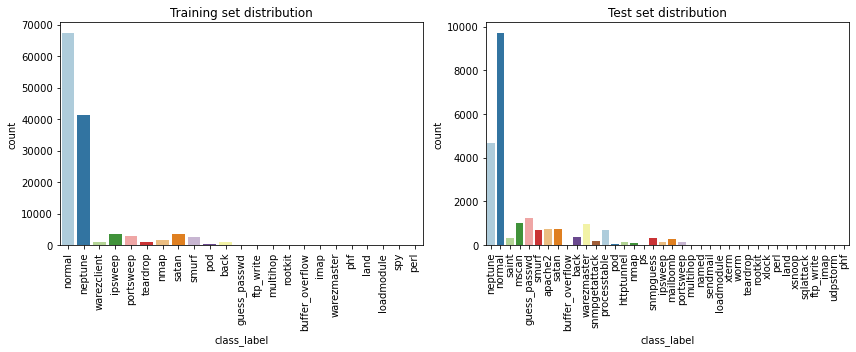

In [5]:
# Plot dataset distribution
data = [df_train, df_test]
title = ['Training set distribution', 'Test set distribution']

fig = plt.figure(figsize = (12, 5))
for i in range(2):
    ax = fig.add_subplot(1,2,i+1)
    p = sns.countplot(x="class_label", data=data[i], palette='Paired')
    p.set_xticklabels(p.get_xticklabels(), rotation=90)
    ax.set_title(title[i])

plt.tight_layout()
plt.show()

## Step 2: Preprocessing

#### Identify categorical features

In [6]:
# Find categorical variables and their corresponding number of categories
print('Training set:')
for i in df_train.select_dtypes(include=['object']).columns.to_list():
    print("Feature '{name}': {count} categories".format(name=i, count=len(df_train[i].unique())))

print('\nTest set:')
for i in df_test.select_dtypes(include=['object']).columns.to_list():
    print("Feature '{name}': {count} categories".format(name=i, count=len(df_test[i].unique())))

Training set:
Feature 'protocol_type': 3 categories
Feature 'service': 70 categories
Feature 'flag': 11 categories
Feature 'class_label': 23 categories

Test set:
Feature 'protocol_type': 3 categories
Feature 'service': 64 categories
Feature 'flag': 11 categories
Feature 'class_label': 38 categories


In [7]:
# Categorical features 
# ('class_label' isnt a feature variable, it's a target variable)
cat_features = ['protocol_type', 'service', 'flag']

#### Apply One-Hot Encoding

In [8]:
# Get binary-encoded dummy values for categorical features
df_train = pd.get_dummies(df_train, columns=cat_features)
df_test = pd.get_dummies(df_test, columns=cat_features)

# Dataset dimensions
print('Training set:', df_train.shape)
print('Test set:', df_test.shape)

Training set: (125973, 123)
Test set: (22544, 117)


**Note:** This contrast in the number of features in training-set versus the number of features in test-set is due to 06 less categories for the feature variable *'service'* in test-set as determined above. To achieve uniformity in data, these missing categories are to be added in test-set.
#### Add missing features in test set

In [9]:
features_to_add = set(df_train.columns) - set(df_test.columns)
for i in features_to_add:
    df_test[i] = 0

# Dataset dimensions
print('Training set:', df_train.shape)
print('Test set:', df_test.shape) 

Training set: (125973, 123)
Test set: (22544, 123)


#### Encode class labels

In [10]:
# Pack class-labels into 4 attack categories and one as normal traffic
# Normal:0 - DoS:1 - Probe:2 - R2L:3 - U2R:4
classes = {0: ['normal'],
           1: ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop', 'apache2', 'udpstorm', 'processtable', 'worm', 'mailbomb'],
           2: ['satan', 'ipsweep', 'nmap', 'portsweep', 'mscan', 'saint'],
           3: ['guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezmaster', 'warezclient', 'spy', 'xsnoop', 'xlock', 
               'snmpguess', 'snmpgetattack', 'httptunnel', 'sendmail', 'named'],
           4: ['buffer_overflow', 'loadmodule', 'rootkit', 'perl', 'xterm', 'sqlattack', 'ps']}

# Perform reverse mapping (i.e., keys->values and values->keys)
classes = {new_k: k for k, v in classes.items() for new_k in v}

# Replace string labels with encoded integers
df_train['class_label'] = df_train['class_label'].map(classes)
df_test['class_label'] = df_test['class_label'].map(classes)

# Display unique class labels
df_train['class_label'].unique()

array([0, 1, 3, 2, 4], dtype=int64)

#### Split data into 4 subsets as per attack category

In [11]:
# Subsets of training set
df_train_DoS = df_train[~df_train['class_label'].isin([2,3,4])]
df_train_Probe = df_train[~df_train['class_label'].isin([1,3,4])]
df_train_R2L = df_train[~df_train['class_label'].isin([1,2,4])]
df_train_U2R = df_train[~df_train['class_label'].isin([1,2,3])]

# Subsets of test set
df_test_DoS = df_test[~df_test['class_label'].isin([2,3,4])]
df_test_Probe = df_test[~df_test['class_label'].isin([1,3,4])]
df_test_R2L = df_test[~df_test['class_label'].isin([1,2,4])]
df_test_U2R = df_test[~df_test['class_label'].isin([1,2,3])]

#### Split data into features and targets

In [12]:
# Training set
X_train_DoS = df_train_DoS.drop('class_label', axis=1)
Y_train_DoS = df_train_DoS['class_label']

X_train_Probe = df_train_Probe.drop('class_label', axis=1)
Y_train_Probe = df_train_Probe['class_label']

X_train_R2L = df_train_R2L.drop('class_label', axis=1)
Y_train_R2L = df_train_R2L['class_label']

X_train_U2R = df_train_U2R.drop('class_label', axis=1)
Y_train_U2R = df_train_U2R['class_label']

In [13]:
# Test set
X_test_DoS = df_test_DoS.drop('class_label', axis=1)
Y_test_DoS = df_test_DoS['class_label']

X_test_Probe = df_test_Probe.drop('class_label', axis=1)
Y_test_Probe = df_test_Probe['class_label']

X_test_R2L = df_test_R2L.drop('class_label', axis=1)
Y_test_R2L = df_test_R2L['class_label']

X_test_U2R = df_test_U2R.drop('class_label', axis=1)
Y_test_U2R = df_test_U2R['class_label']

In [14]:
# Store features and target names (for later use)
# Features (same for all attacks)
features = X_test_DoS.columns

# Training
target = ['class_label']

## Step 3: Feature Scaling

In [15]:
# Training set
X_train_DoS = StandardScaler().fit(X_train_DoS).transform(X_train_DoS)
X_train_Probe = StandardScaler().fit(X_train_Probe).transform(X_train_Probe)
X_train_R2L = StandardScaler().fit(X_train_R2L).transform(X_train_R2L)
X_train_U2R = StandardScaler().fit(X_train_U2R).transform(X_train_U2R)

# Test set
X_test_DoS = StandardScaler().fit(X_test_DoS).transform(X_test_DoS)
X_test_Probe = StandardScaler().fit(X_test_Probe).transform(X_test_Probe)
X_test_R2L = StandardScaler().fit(X_test_R2L).transform(X_test_R2L)
X_test_U2R = StandardScaler().fit(X_test_U2R).transform(X_test_U2R)

## Step 4: Feature Selection

### a. Univariate feature selection with ANOVA F-test

In [16]:
# Create selector object that would select features according to a percentile of highest score
S = SelectPercentile(f_classif, percentile=10)

In [17]:
# DoS attack training data
X_train_DoS_anova = S.fit_transform(X_train_DoS, Y_train_DoS)
dos_features_anova = features[S.get_support().nonzero()[0]].to_list()

print("DoS-attack:", X_train_DoS_anova.shape)
print("Features:", "\n\t  ".join(map(str, dos_features_anova)))

DoS-attack: (113270, 13)
Features: logged_in
	  count
	  serror_rate
	  srv_serror_rate
	  same_srv_rate
	  dst_host_count
	  dst_host_srv_count
	  dst_host_same_srv_rate
	  dst_host_serror_rate
	  dst_host_srv_serror_rate
	  service_imap4
	  service_http_8001
	  service_harvest


In [18]:
# Probe attack training data
X_train_Probe_anova = S.fit_transform(X_train_Probe, Y_train_Probe)
probe_features_anova = features[S.get_support().nonzero()[0]].to_list()

print("Probe-attack:", X_train_Probe_anova.shape)
print("Features:", "\n\t  ".join(map(str, probe_features_anova)))

Probe-attack: (78999, 13)
Features: logged_in
	  rerror_rate
	  srv_rerror_rate
	  dst_host_srv_count
	  dst_host_diff_srv_rate
	  dst_host_same_src_port_rate
	  dst_host_srv_diff_host_rate
	  dst_host_rerror_rate
	  dst_host_srv_rerror_rate
	  protocol_type_icmp
	  service_ecr_i
	  service_smtp
	  service_harvest


In [19]:
# R2L attack training data
X_train_R2L_anova = S.fit_transform(X_train_R2L, Y_train_R2L)
r2l_features_anova = features[S.get_support().nonzero()[0]].to_list()

print("R2L-attack:", X_train_R2L_anova.shape)
print("Features:", "\n\t  ".join(map(str, r2l_features_anova)))

R2L-attack: (68338, 13)
Features: src_bytes
	  dst_bytes
	  hot
	  num_failed_logins
	  is_guest_login
	  dst_host_srv_count
	  dst_host_same_src_port_rate
	  dst_host_srv_diff_host_rate
	  service_ftp_data
	  service_gopher
	  service_imap4
	  service_ldap
	  flag_S3


In [20]:
# U2R attack training data
X_train_U2R_anova = S.fit_transform(X_train_U2R, Y_train_U2R)
u2r_features_anova = features[S.get_support().nonzero()[0]].to_list()

print("U2R-attack:", X_train_U2R_anova.shape)
print("Features:", "\n\t  ".join(map(str, u2r_features_anova)))

U2R-attack: (67395, 13)
Features: urgent
	  hot
	  root_shell
	  num_file_creations
	  num_shells
	  srv_diff_host_rate
	  dst_host_count
	  dst_host_srv_count
	  dst_host_same_src_port_rate
	  dst_host_srv_diff_host_rate
	  service_gopher
	  service_imap4
	  service_uucp


### b. Recursive Feature Elimination (RFE) - ranking anova features

In [21]:
# Create RFE object to begin ranking the features
rfe = RFE(estimator = DecisionTreeClassifier(), n_features_to_select = 1)

In [22]:
# Rank DoS attack features
rfe.fit(X_train_DoS_anova, Y_train_DoS)
print("DoS-attack features ranking:", *sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), dos_features_anova)), sep="\n\t\t\t   ")

DoS-attack features ranking:
			   (1, 'same_srv_rate')
			   (2, 'count')
			   (3, 'service_harvest')
			   (4, 'dst_host_serror_rate')
			   (5, 'dst_host_same_srv_rate')
			   (6, 'dst_host_srv_count')
			   (7, 'dst_host_count')
			   (8, 'logged_in')
			   (9, 'dst_host_srv_serror_rate')
			   (10, 'srv_serror_rate')
			   (11, 'serror_rate')
			   (12, 'service_imap4')
			   (13, 'service_http_8001')


In [23]:
# Rank Probe attack features
rfe.fit(X_train_Probe_anova, Y_train_Probe)
print("Probe-attack features ranking:", *sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), probe_features_anova)), sep="\n\t\t\t   ")

Probe-attack features ranking:
			   (1, 'dst_host_same_src_port_rate')
			   (2, 'dst_host_srv_count')
			   (3, 'dst_host_rerror_rate')
			   (4, 'service_smtp')
			   (5, 'logged_in')
			   (6, 'dst_host_diff_srv_rate')
			   (7, 'dst_host_srv_diff_host_rate')
			   (8, 'service_harvest')
			   (9, 'service_ecr_i')
			   (10, 'rerror_rate')
			   (11, 'protocol_type_icmp')
			   (12, 'dst_host_srv_rerror_rate')
			   (13, 'srv_rerror_rate')


In [24]:
# Rank R2L attack features
rfe.fit(X_train_R2L_anova, Y_train_R2L)
print("R2L-attack features ranking:", *sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), r2l_features_anova)), sep="\n\t\t\t   ")

R2L-attack features ranking:
			   (1, 'src_bytes')
			   (2, 'dst_bytes')
			   (3, 'hot')
			   (4, 'dst_host_srv_diff_host_rate')
			   (5, 'service_gopher')
			   (6, 'dst_host_same_src_port_rate')
			   (7, 'dst_host_srv_count')
			   (8, 'num_failed_logins')
			   (9, 'service_ldap')
			   (10, 'is_guest_login')
			   (11, 'flag_S3')
			   (12, 'service_ftp_data')
			   (13, 'service_imap4')


In [25]:
# Rank U2R attack features
rfe.fit(X_train_U2R_anova, Y_train_U2R)
print("U2R-attack features ranking:", *sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), u2r_features_anova)), sep="\n\t\t\t   ")

U2R-attack features ranking:
			   (1, 'hot')
			   (2, 'dst_host_srv_count')
			   (3, 'dst_host_count')
			   (4, 'root_shell')
			   (5, 'num_shells')
			   (6, 'dst_host_srv_diff_host_rate')
			   (7, 'service_gopher')
			   (8, 'dst_host_same_src_port_rate')
			   (9, 'num_file_creations')
			   (10, 'service_uucp')
			   (11, 'srv_diff_host_rate')
			   (12, 'service_imap4')
			   (13, 'urgent')


### c. Recursive Feature Elimination (RFE) - get 13 best features out of 122

In [26]:
# Create RFE object to begin ranking the features
rfe = RFE(estimator = DecisionTreeClassifier(), 
          n_features_to_select = 13, 
          step = 1)

In [27]:
# Rank DoS attack features
rfe.fit(X_train_DoS, Y_train_DoS)
X_train_DoS_rfe = rfe.transform(X_train_DoS)

# Get rfe best feature names
dos_features_idx_rfe = rfe.support_.nonzero()[0]
dos_features_rfe = features[dos_features_idx_rfe].to_list()
print("Features:", "\n\t  ".join(dos_features_rfe))

Features: src_bytes
	  dst_bytes
	  wrong_fragment
	  num_compromised
	  same_srv_rate
	  diff_srv_rate
	  dst_host_count
	  dst_host_diff_srv_rate
	  dst_host_serror_rate
	  dst_host_srv_serror_rate
	  service_efs
	  flag_SH
	  service_http_8001


In [28]:
# Rank Probe attack features
rfe.fit(X_train_Probe, Y_train_Probe)
X_train_Probe_rfe = rfe.transform(X_train_Probe)

# Get rfe best feature names
probe_features_idx_rfe = rfe.support_.nonzero()[0]
probe_features_rfe = features[probe_features_idx_rfe].to_list()
print("Features:", "\n\t  ".join(probe_features_rfe))

Features: src_bytes
	  dst_bytes
	  rerror_rate
	  dst_host_same_srv_rate
	  dst_host_diff_srv_rate
	  dst_host_same_src_port_rate
	  dst_host_rerror_rate
	  service_ftp
	  service_gopher
	  service_imap4
	  service_smtp
	  service_systat
	  service_uucp


In [29]:
# Rank R2L attack features
rfe.fit(X_train_R2L, Y_train_R2L)
X_train_R2L_rfe = rfe.transform(X_train_R2L)

# Get rfe best feature names
r2l_features_idx_rfe = rfe.support_.nonzero()[0]
r2l_features_rfe = features[r2l_features_idx_rfe].to_list()
print("Features:", "\n\t  ".join(r2l_features_rfe))

Features: duration
	  src_bytes
	  dst_bytes
	  hot
	  num_failed_logins
	  num_access_files
	  dst_host_srv_count
	  dst_host_same_srv_rate
	  dst_host_same_src_port_rate
	  dst_host_srv_diff_host_rate
	  dst_host_serror_rate
	  service_gopher
	  service_ldap


In [30]:
# Rank U2R attack features
rfe.fit(X_train_U2R, Y_train_U2R)
X_train_U2R_rfe = rfe.transform(X_train_U2R)

# Get rfe best feature names
u2r_features_idx_rfe = rfe.support_.nonzero()[0]
u2r_features_rfe = features[u2r_features_idx_rfe].to_list()
print("Features:", "\n\t  ".join(u2r_features_rfe))

Features: duration
	  src_bytes
	  dst_bytes
	  hot
	  root_shell
	  num_file_creations
	  num_shells
	  srv_count
	  dst_host_count
	  dst_host_same_srv_rate
	  dst_host_srv_diff_host_rate
	  service_gopher
	  service_printer


## Step 5: Build classifier model
#### For all features

In [31]:
clf_DoS = DecisionTreeClassifier(random_state = 394)
clf_DoS.fit(X_train_DoS, Y_train_DoS)

clf_Probe = DecisionTreeClassifier(random_state = 394)
clf_Probe.fit(X_train_Probe, Y_train_Probe)

clf_R2L = DecisionTreeClassifier(random_state = 394)
clf_R2L.fit(X_train_R2L, Y_train_R2L)

clf_U2R = DecisionTreeClassifier(random_state = 394)
clf_U2R.fit(X_train_U2R, Y_train_U2R)

DecisionTreeClassifier(random_state=394)

#### For reduced features

In [32]:
clf_DoS_rfe = DecisionTreeClassifier(random_state = 394)
clf_DoS_rfe.fit(X_train_DoS_rfe, Y_train_DoS)

clf_Probe_rfe = DecisionTreeClassifier(random_state = 394)
clf_Probe_rfe.fit(X_train_Probe_rfe, Y_train_Probe)

clf_R2L_rfe = DecisionTreeClassifier(random_state = 394)
clf_R2L_rfe.fit(X_train_R2L_rfe, Y_train_R2L)

clf_U2R_rfe = DecisionTreeClassifier(random_state = 394)
clf_U2R_rfe.fit(X_train_U2R_rfe, Y_train_U2R)

DecisionTreeClassifier(random_state=394)

## Step 6: Prediction and Evaluation

### a. DoS Attack

#### For all features

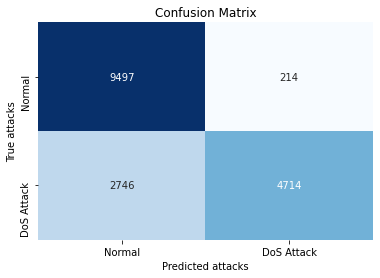

In [33]:
# Evaluate on DoS attack test data
Y_pred_DoS = clf_DoS.predict(X_test_DoS)

# Plot confusion matrix
ax = plt.subplot()
sns.heatmap(confusion_matrix(Y_test_DoS, Y_pred_DoS), annot=True, fmt='g', cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel('Predicted attacks')
ax.set_ylabel('True attacks')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Normal', 'DoS Attack'])
ax.yaxis.set_ticklabels(['Normal', 'DoS Attack'])
plt.show()

In [34]:
# Performance metrics
accuracy = cross_val_score(clf_DoS, X_test_DoS, Y_test_DoS, cv=10, scoring='accuracy')
precision = cross_val_score(clf_DoS, X_test_DoS, Y_test_DoS, cv=10, scoring='precision')
recall = cross_val_score(clf_DoS, X_test_DoS, Y_test_DoS, cv=10, scoring='recall')
f1_score = cross_val_score(clf_DoS, X_test_DoS, Y_test_DoS, cv=10, scoring='f1')

print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
print("F-measure: %0.5f (+/- %0.5f)" % (f1_score.mean(), f1_score.std() * 2))

Accuracy: 0.99651 (+/- 0.00357)
Precision: 0.99518 (+/- 0.00480)
Recall: 0.99678 (+/- 0.00452)
F-measure: 0.99598 (+/- 0.00410)


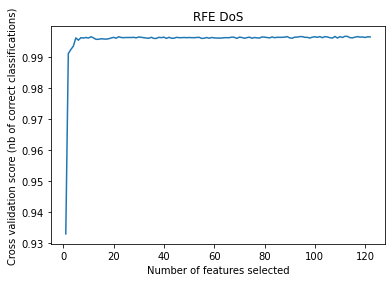

In [35]:
# Fit RFECV on DoS attack test data with 10-fold cross-validation
rfecv_DoS = RFECV(estimator=clf_DoS, step=1, cv=10, scoring='accuracy')
rfecv_DoS.fit(X_test_DoS, Y_test_DoS)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.plot(range(1, len(rfecv_DoS.grid_scores_) + 1), rfecv_DoS.grid_scores_)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFE DoS')
plt.show()

#### For reduced features

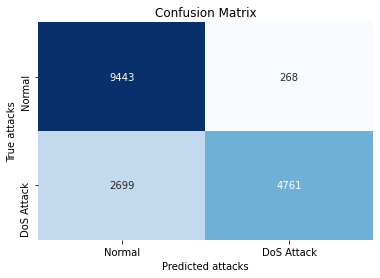

In [36]:
# DoS attack test data with 13 best features
X_test_DoS_rfe = X_test_DoS[:, dos_features_idx_rfe]

# Evaluate on DoS attack test data
Y_pred_DoS_rfe = clf_DoS_rfe.predict(X_test_DoS_rfe)

# Plot confusion matrix
ax = plt.subplot()
sns.heatmap(confusion_matrix(Y_test_DoS, Y_pred_DoS_rfe), annot=True, fmt='g', cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel('Predicted attacks')
ax.set_ylabel('True attacks')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Normal', 'DoS Attack'])
ax.yaxis.set_ticklabels(['Normal', 'DoS Attack'])
plt.show()

In [37]:
# Performance metrics
accuracy = cross_val_score(clf_DoS_rfe, X_test_DoS_rfe, Y_test_DoS, cv=10, scoring='accuracy')
precision = cross_val_score(clf_DoS_rfe, X_test_DoS_rfe, Y_test_DoS, cv=10, scoring='precision')
recall = cross_val_score(clf_DoS_rfe, X_test_DoS_rfe, Y_test_DoS, cv=10, scoring='recall')
f1_score = cross_val_score(clf_DoS_rfe, X_test_DoS_rfe, Y_test_DoS, cv=10, scoring='f1')

print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
print("F-measure: %0.5f (+/- %0.5f)" % (f1_score.mean(), f1_score.std() * 2))

Accuracy: 0.99703 (+/- 0.00306)
Precision: 0.99612 (+/- 0.00511)
Recall: 0.99705 (+/- 0.00429)
F-measure: 0.99658 (+/- 0.00351)


### b. Probe Attack

#### For all features

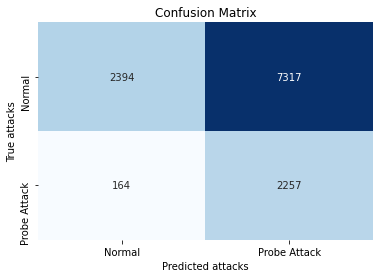

In [38]:
# Evaluate on Probe attack test data
Y_pred_Probe = clf_Probe.predict(X_test_Probe)

# Plot confusion matrix
ax = plt.subplot()
sns.heatmap(confusion_matrix(Y_test_Probe, Y_pred_Probe), annot=True, fmt='g', cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel('Predicted attacks')
ax.set_ylabel('True attacks')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Normal', 'Probe Attack'])
ax.yaxis.set_ticklabels(['Normal', 'Probe Attack'])
plt.show()

In [39]:
# Performance metrics
accuracy = cross_val_score(clf_Probe, X_test_Probe, Y_test_Probe, cv=10, scoring='accuracy')
precision = cross_val_score(clf_Probe, X_test_Probe, Y_test_Probe, cv=10, scoring='precision_macro')
recall = cross_val_score(clf_Probe, X_test_Probe, Y_test_Probe, cv=10, scoring='recall_macro')
f1_score = cross_val_score(clf_Probe, X_test_Probe, Y_test_Probe, cv=10, scoring='f1_macro')

print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
print("F-measure: %0.5f (+/- %0.5f)" % (f1_score.mean(), f1_score.std() * 2))

Accuracy: 0.99580 (+/- 0.00349)
Precision: 0.99322 (+/- 0.00733)
Recall: 0.99365 (+/- 0.00450)
F-measure: 0.99343 (+/- 0.00544)


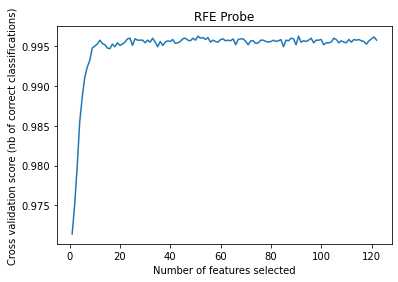

In [40]:
# Fit RFECV on Probe attack test data with 10-fold cross-validation
rfecv_Probe = RFECV(estimator=clf_Probe, step=1, cv=10, scoring='accuracy')
rfecv_Probe.fit(X_test_Probe, Y_test_Probe)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.plot(range(1, len(rfecv_Probe.grid_scores_) + 1), rfecv_Probe.grid_scores_)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFE Probe')
plt.show()

#### For reduced features

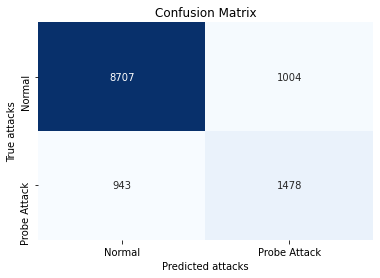

In [41]:
# Probe attack test data with 13 best features
X_test_Probe_rfe = X_test_Probe[:, probe_features_idx_rfe]

# Evaluate on Probe attack test data
Y_pred_Probe_rfe = clf_Probe_rfe.predict(X_test_Probe_rfe)

# Plot confusion matrix
ax = plt.subplot()
sns.heatmap(confusion_matrix(Y_test_Probe, Y_pred_Probe_rfe), annot=True, fmt='g', cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel('Predicted attacks')
ax.set_ylabel('True attacks')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Normal', 'Probe Attack'])
ax.yaxis.set_ticklabels(['Normal', 'Probe Attack'])
plt.show()

In [42]:
# Performance metrics
accuracy = cross_val_score(clf_Probe_rfe, X_test_Probe_rfe, Y_test_Probe, cv=10, scoring='accuracy')
precision = cross_val_score(clf_Probe_rfe, X_test_Probe_rfe, Y_test_Probe, cv=10, scoring='precision_macro')
recall = cross_val_score(clf_Probe_rfe, X_test_Probe_rfe, Y_test_Probe, cv=10, scoring='recall_macro')
f1_score = cross_val_score(clf_Probe_rfe, X_test_Probe_rfe, Y_test_Probe, cv=10, scoring='f1_macro')

print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
print("F-measure: %0.5f (+/- %0.5f)" % (f1_score.mean(), f1_score.std() * 2))

Accuracy: 0.99077 (+/- 0.00561)
Precision: 0.98683 (+/- 0.01137)
Recall: 0.98431 (+/- 0.01056)
F-measure: 0.98552 (+/- 0.00875)


### c. R2L Attack

#### For all features

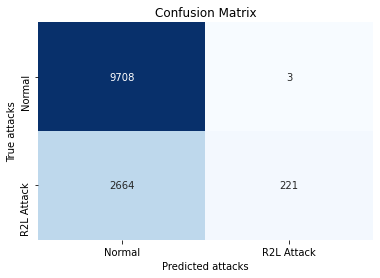

In [43]:
# Evaluate on R2L attack test data
Y_pred_R2L = clf_R2L.predict(X_test_R2L)

# Plot confusion matrix
ax = plt.subplot()
sns.heatmap(confusion_matrix(Y_test_R2L, Y_pred_R2L), annot=True, fmt='g', cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel('Predicted attacks')
ax.set_ylabel('True attacks')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Normal', 'R2L Attack'])
ax.yaxis.set_ticklabels(['Normal', 'R2L Attack'])
plt.show()

In [44]:
# Performance metrics
accuracy = cross_val_score(clf_R2L, X_test_R2L, Y_test_R2L, cv=10, scoring='accuracy')
precision = cross_val_score(clf_R2L, X_test_R2L, Y_test_R2L, cv=10, scoring='precision_macro')
recall = cross_val_score(clf_R2L, X_test_R2L, Y_test_R2L, cv=10, scoring='recall_macro')
f1_score = cross_val_score(clf_R2L, X_test_R2L, Y_test_R2L, cv=10, scoring='f1_macro')

print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
print("F-measure: %0.5f (+/- %0.5f)" % (f1_score.mean(), f1_score.std() * 2))

Accuracy: 0.97960 (+/- 0.01100)
Precision: 0.97212 (+/- 0.01755)
Recall: 0.97007 (+/- 0.01485)
F-measure: 0.97106 (+/- 0.01548)


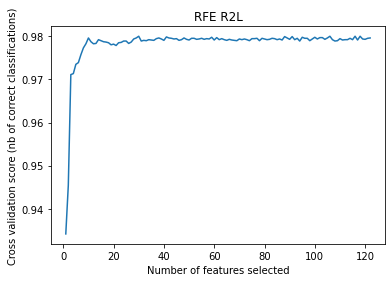

In [45]:
# Fit RFECV on R2L attack test data with 10-fold cross-validation
rfecv_R2L = RFECV(estimator=clf_R2L, step=1, cv=10, scoring='accuracy')
rfecv_R2L.fit(X_test_R2L, Y_test_R2L)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.plot(range(1, len(rfecv_R2L.grid_scores_) + 1), rfecv_R2L.grid_scores_)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFE R2L')
plt.show()

#### For reduced features

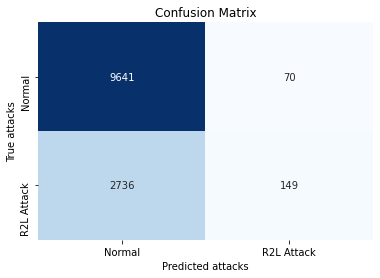

In [46]:
# R2L attack test data with 13 best features
X_test_R2L_rfe = X_test_R2L[:, r2l_features_idx_rfe]

# Evaluate on R2L attack test data
Y_pred_R2L_rfe = clf_R2L_rfe.predict(X_test_R2L_rfe)

# Plot confusion matrix
ax = plt.subplot()
sns.heatmap(confusion_matrix(Y_test_R2L, Y_pred_R2L_rfe), annot=True, fmt='g', cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel('Predicted attacks')
ax.set_ylabel('True attacks')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Normal', 'R2L Attack'])
ax.yaxis.set_ticklabels(['Normal', 'R2L Attack'])
plt.show()

In [47]:
# Performance metrics
accuracy = cross_val_score(clf_R2L_rfe, X_test_R2L_rfe, Y_test_R2L, cv=10, scoring='accuracy')
precision = cross_val_score(clf_R2L_rfe, X_test_R2L_rfe, Y_test_R2L, cv=10, scoring='precision_macro')
recall = cross_val_score(clf_R2L_rfe, X_test_R2L_rfe, Y_test_R2L, cv=10, scoring='recall_macro')
f1_score = cross_val_score(clf_R2L_rfe, X_test_R2L_rfe, Y_test_R2L, cv=10, scoring='f1_macro')

print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
print("F-measure: %0.5f (+/- %0.5f)" % (f1_score.mean(), f1_score.std() * 2))

Accuracy: 0.97698 (+/- 0.00825)
Precision: 0.97063 (+/- 0.01245)
Recall: 0.96387 (+/- 0.01311)
F-measure: 0.96717 (+/- 0.01178)


### d. U2R Attack

#### For all features

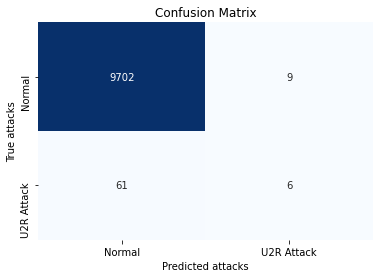

In [48]:
# Evaluate on U2R attack test data
Y_pred_U2R = clf_U2R.predict(X_test_U2R)

# Plot confusion matrix
ax = plt.subplot()
sns.heatmap(confusion_matrix(Y_test_U2R, Y_pred_U2R), annot=True, fmt='g', cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel('Predicted attacks')
ax.set_ylabel('True attacks')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Normal', 'U2R Attack'])
ax.yaxis.set_ticklabels(['Normal', 'U2R Attack'])
plt.show()

In [49]:
# Performance metrics
accuracy = cross_val_score(clf_U2R, X_test_U2R, Y_test_U2R, cv=10, scoring='accuracy')
precision = cross_val_score(clf_U2R, X_test_U2R, Y_test_U2R, cv=10, scoring='precision_macro')
recall = cross_val_score(clf_U2R, X_test_U2R, Y_test_U2R, cv=10, scoring='recall_macro')
f1_score = cross_val_score(clf_U2R, X_test_U2R, Y_test_U2R, cv=10, scoring='f1_macro')

print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
print("F-measure: %0.5f (+/- %0.5f)" % (f1_score.mean(), f1_score.std() * 2))

Accuracy: 0.99642 (+/- 0.00333)
Precision: 0.86415 (+/- 0.13642)
Recall: 0.90244 (+/- 0.09692)
F-measure: 0.87890 (+/- 0.09697)


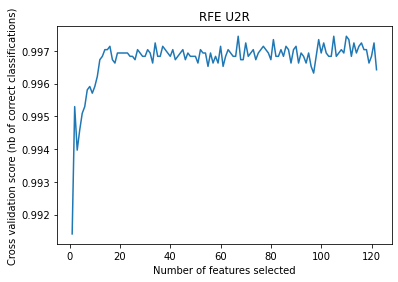

In [50]:
# Fit RFECV on U2R attack test data with 10-fold cross-validation
rfecv_U2R = RFECV(estimator=clf_U2R, step=1, cv=10, scoring='accuracy')
rfecv_U2R.fit(X_test_U2R, Y_test_U2R)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.plot(range(1, len(rfecv_U2R.grid_scores_) + 1), rfecv_U2R.grid_scores_)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFE U2R')
plt.show()

#### For reduced features

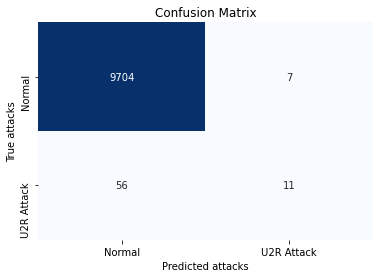

In [51]:
# U2R attack test data with 13 best features
X_test_U2R_rfe = X_test_U2R[:, u2r_features_idx_rfe]

# Evaluate on U2R attack test data
Y_pred_U2R_rfe = clf_U2R_rfe.predict(X_test_U2R_rfe)

# Plot confusion matrix
ax = plt.subplot()
sns.heatmap(confusion_matrix(Y_test_U2R, Y_pred_U2R_rfe), annot=True, fmt='g', cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel('Predicted attacks')
ax.set_ylabel('True attacks')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Normal', 'U2R Attack'])
ax.yaxis.set_ticklabels(['Normal', 'U2R Attack'])
plt.show()

In [52]:
# Performance metrics
accuracy = cross_val_score(clf_U2R_rfe, X_test_U2R_rfe, Y_test_U2R, cv=10, scoring='accuracy')
precision = cross_val_score(clf_U2R_rfe, X_test_U2R_rfe, Y_test_U2R, cv=10, scoring='precision_macro')
recall = cross_val_score(clf_U2R_rfe, X_test_U2R_rfe, Y_test_U2R, cv=10, scoring='recall_macro')
f1_score = cross_val_score(clf_U2R_rfe, X_test_U2R_rfe, Y_test_U2R, cv=10, scoring='f1_macro')

print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
print("F-measure: %0.5f (+/- %0.5f)" % (f1_score.mean(), f1_score.std() * 2))

Accuracy: 0.99591 (+/- 0.00317)
Precision: 0.85670 (+/- 0.16618)
Recall: 0.87382 (+/- 0.12877)
F-measure: 0.85790 (+/- 0.09946)
